# Defining Functions

In [191]:
def PredictSprints(CsvFile,Player,Match):
    import numpy as np
    import pandas as pd
    import joblib
    from scipy import signal
    import statistics as cal
    import matplotlib.pyplot as plt
    
    ######################################### Defining Data preparation function ########################################################
    def Dataloader(CsvFile, ChunkSize, ChunkOverlap, OperationList):
        df = pd.read_csv(CsvFile)
        df = df.fillna(0)
        chunks = [df[i:i+ChunkSize] for i in range(0,df.shape[0],ChunkOverlap)]
        frames = []

        for chunk in chunks:
            chunk = chunk.drop(columns=['Unnamed: 0'])
            frames.append(chunk)


        df_end =[]

        for frame in frames:
            if len(frame) == 100:
                result = [] #Reset the result array
                for column in list(frame.columns):

                    if column in OperationList: #Check if column is in namelist

                        if OperationList[str(column)].values == 'cal.mean': #You can at more function if you want
                            X = cal.mean(frame[str(column)].tolist()) #Calculate mean of all columns named in namelist with operation cal.mean

                        else: #If the given operations isn't cal.mean
                            frame[str(column)] = [abs(ele) for ele in frame[str(column)]] #Get absolute value of all elements in list
                            X = max(frame[str(column)].tolist()) #Get single max value from list 

                    else:
                        frame[str(column)] = [abs(ele) for ele in frame[str(column)]] #Get absolute value of all elements in list
                        X = max(frame[str(column)].tolist()) #Get single max value from list

                    result.append(X) #Append results to list

                df_end.append(result) #Append all results into one big list

        df_end = pd.DataFrame(df_end, columns = list(frame.columns)) #Convert list to df
        return(df_end)
    
    ######################################### Define LowPass-Filter ########################################################
    def LpFilter(df_test):
        Order = 5
        cutoff_freq = 1.5
        sampling_freq = 100
        sampling_duration = len(df_test)

        normalized_cutoff_freq = 2 * cutoff_freq / sampling_freq
        numerator_coeffs, denominator_coeffs = signal.butter(Order, normalized_cutoff_freq)
        df_test['Filt_FrameZ'] = signal.lfilter(numerator_coeffs, denominator_coeffs, df_test.frameRotationalSpeedZ)
        
    ######################################### Main #######################################################################    
    df_test = Dataloader(CsvFile, 100, 50, [{ 'wheelRotationalSpeedX' : ['Cal.mean']}])

    LpFilter(df_test)
    
    ######################################### Differnatial equation #######################################################################
    df_test['wheelRotationalSpeedXDiff'] = np.insert(np.diff(df_test.wheelRotationalSpeedX,n=1),0,0)
    
    ######################################### Math functions #######################################################################
    df_test['Sum_WheelX_FrameZ'] = df_test.wheelRotationalSpeedX + df_test.frameRotationalSpeedZ
    
    columns = ['timeLine','frSpeed','frAcc','wheelRotationalSpeedXDiff','frRoAcc',
           'frameRotationalSpeedZ','wheelRotationalSpeedX','Filt_FrameZ' ]

    X_test = df_test[columns]
    
    #Calculating results
    filename = 'RFC_Model.sav'
    model = joblib.load(filename)
    X_test['Sprinting'] = model.predict(X_test)
    
    #Formatting results
    df_results = pd.DataFrame(X_test)
    
    df = pd.read_csv(CsvFile)
    
    Sprinting = df_results.Sprinting.to_numpy()
    timeLine = df_results.timeLine.to_numpy() 
    
    Sprint = False;
    SprintStart = []
    SprintStop = []
    
    for i in range(0,len(Sprinting)):
        if Sprint == False and Sprinting[i] == 1:
            SprintStart.append(timeLine[i])
            Sprint = True
        elif Sprint == True and Sprinting[i] == False:
            SprintStop.append(timeLine[i])
            Sprint = False
    
    Deleted = 0
    
    for i in range(0,len(SprintStart),1):
        if (SprintStop[i-Deleted] - SprintStart[i-Deleted]) <= 2.5:
            SprintStart.pop(i-Deleted)
            SprintStop.pop(i-Deleted)
            Deleted = Deleted + 1
            
          
    for i in range(0,len(SprintStart),1):   
        df.loc[(df['timeLine'] >= SprintStart[i]) & (df['timeLine'] <= SprintStop[i]), 'Sprinting'] = 1
#        if SprintStop[i] - SprintStart[i] > 12:
#            plt.plot(df.timeLine[df['timeLine'].between(SprintStart[i], SprintStop[i])],df.wheelRotationalSpeedX[df_raw['timeLine'].between(SprintStart[i], SprintStop[i])], 'r',
#                    df.timeLine[df['timeLine'].between(SprintStart[i], SprintStop[i])],df.frameRotationalSpeedZ[df['timeLine'].between(SprintStart[i], SprintStop[i])], 'b') 
#            plt.show()
    
    # Print statistical information
    print('Amount of sprints: '+str(len(SprintStart)))
    
    x = np.subtract(SprintStop, SprintStart)
    plt.hist(x, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
    plt.title("Histogram of Sprint Durations")
    plt.ylabel('Amount of sprints')
    plt.xlabel('Duration (s)')
    plt.show()
    
    df = df.fillna(0)
    df = df.drop(columns = ['Unnamed: 0'])
    
    Mean = cal.mean(df.wheelRotationalSpeedX[(df.Sprinting == 1)].to_numpy())
    print('The mean of the speed of the sprints: ' + str(Mean))
    
    df.to_csv('Results_RF_Player'+str(Player)+'_Match'+str(Match)+'.csv')
    return df

/tmp/ipykernel_27124/530821710.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Sprinting'] = model.predict(X_test)


Amount of sprints: 128
The mean of the speed of the sprints: 459.08960830418744


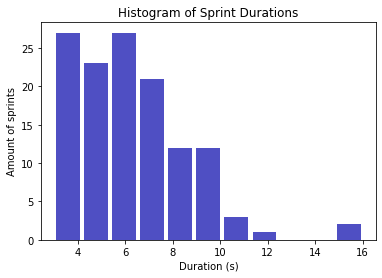

In [192]:
df = PredictSprints('matrix_Player_8_game_2_QuarterSplit.csv',8,2)